# TF isoform data


## TODO

- check valid clones only in all data
- get sequence information
- remove partners that didn't test positive with any isoform
- remove single isoforms
    - but need to add first to paralogs
- Look into effect of number of PPIs per TF
- combine categories to get paralog data

In [1]:
import os
from itertools import combinations

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

import ccsblib
from ccsblib import ccsbplotlib as cplt

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_rna_expression_data,
                          load_seq_comparison_data)
from isoform_pairwise_metrics import pairs_of_isoforms_comparison_table

%matplotlib inline

y2h = load_isoform_and_paralog_y2h_data()
y1h = load_y1h_pdi_data()
# m1h = load_m1h_activation_data()
#tfs, ptrs, = load_rna_expression_data()
isoforms = load_valid_isoform_clones()
idents = load_seq_comparison_data()

#tfs = tfs.drop(columns=['tpm_stdev'])
#tfs = tfs.set_index(['gene', 'isoacc', 'tiss'])
#tfs = tfs.unstack(level='tiss')
#tfs.columns = tfs.columns.get_level_values(1)

#tfs.to_csv('tf_isoform_tissue_tpms.tsv', sep='\t')

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
ppi = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['category',
               'ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'score']].copy()
ppi = ppi.loc[ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['score']
                 .transform(lambda row: (row == '1').any()),
              :]
ppi = ppi.loc[ppi.groupby('ad_clone_acc')
                  ['score']
                  .transform(lambda x: (x.isin(['0', '1']).any())),
              :]
ppi = ppi.loc[ppi.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
# rna = load_rna_expression_data()
isoforms = load_valid_isoform_clones()
iso_pairs = pairs_of_isoforms_comparison_table(isoforms=isoforms,
                                               y2h=ppi,
                                               y1h=y1h,
                                               m1h=m1h)

In [3]:
iso_pairs['pdi_n_max'] = iso_pairs['pdi_n_tested'] - (iso_pairs['pdi_n_min'] - iso_pairs['pdi_n_shared'])

In [4]:
iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(),
              ['tf_gene_symbol',
               'clone_acc_a',
               'clone_acc_b',
               'pdi_jaccard',
               'pdi_n_min',
               'pdi_n_max']].to_csv('/Users/lukelambourne/Desktop/PDI_isoform_pairs.tsv', sep='\t', index=False)

In [5]:
iso_pairs.shape

(806, 21)

In [6]:
(isoforms.groupby('gene').size() >= 2).sum()

249

In [7]:
iso_pairs.notnull().sum()

tf_gene_symbol            806
clone_acc_a               806
clone_acc_b               806
pair                      806
ppi_n_tested              322
ppi_n_shared              322
ppi_n_min                 322
ppi_n_min_diff            322
ppi_jaccard               322
ppi_simpson               172
ppi_n_diff                322
pdi_n_tested              117
pdi_n_shared              117
pdi_n_min                 117
pdi_n_min_diff            117
pdi_jaccard               117
pdi_simpson                65
pdi_n_diff                117
activation_fold_change    615
aa_seq_pct_id             806
pdi_n_max                 117
dtype: int64

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


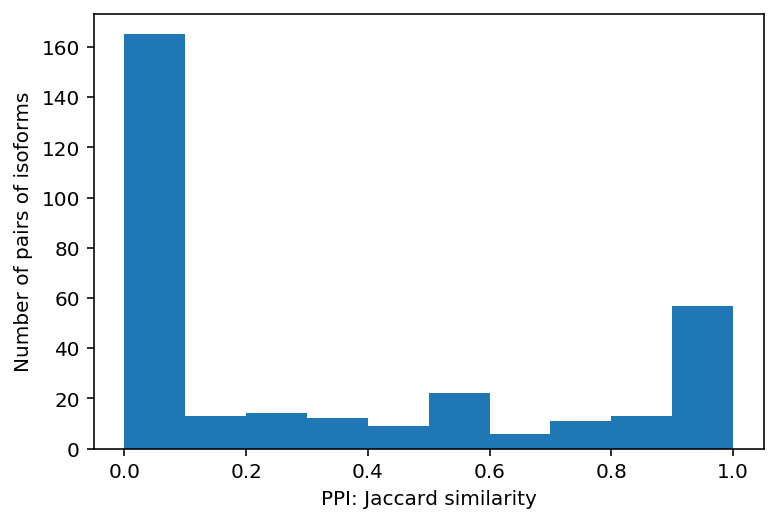

In [8]:
fig, ax = plt.subplots(1, 1)
ax.hist(iso_pairs['ppi_jaccard'], range=(0, 1), bins=10)
ax.set_ylabel('Number of pairs of isoforms')
ax.set_xlabel('PPI: Jaccard similarity')
plt.savefig('../../figures/ppi_jaccard_dist.pdf')

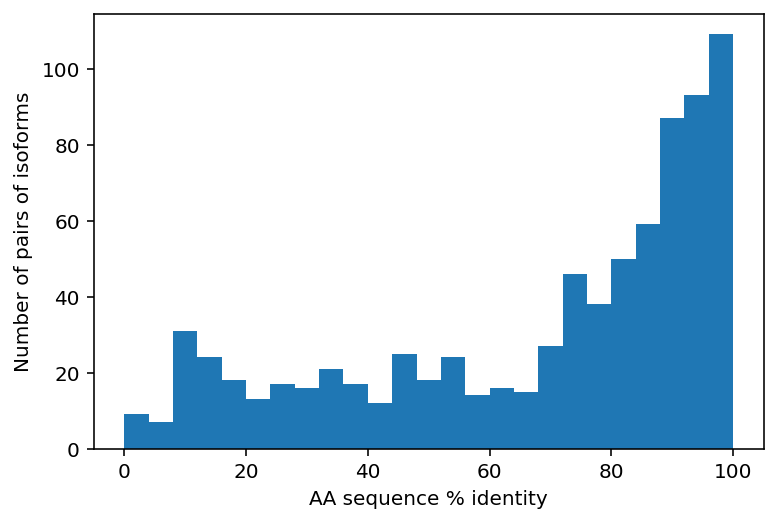

In [9]:
fig, ax = plt.subplots(1, 1)
ax.hist(iso_pairs['aa_seq_pct_id'], range=(0, 100), bins=25)
ax.set_ylabel('Number of pairs of isoforms')
ax.set_xlabel('AA sequence % identity')
plt.savefig('../../figures/aa_seq_pct_id_hist.pdf')

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


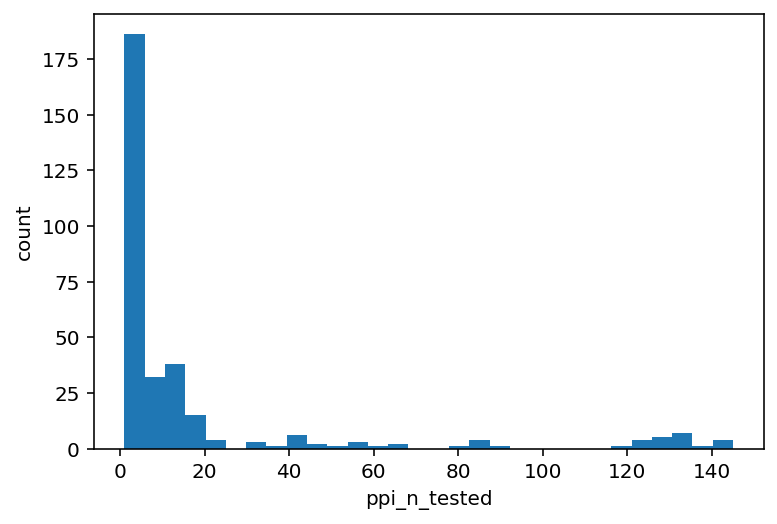

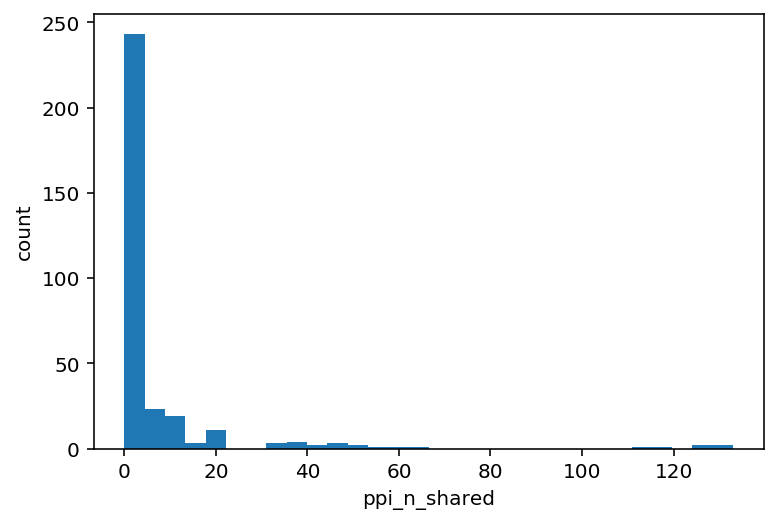

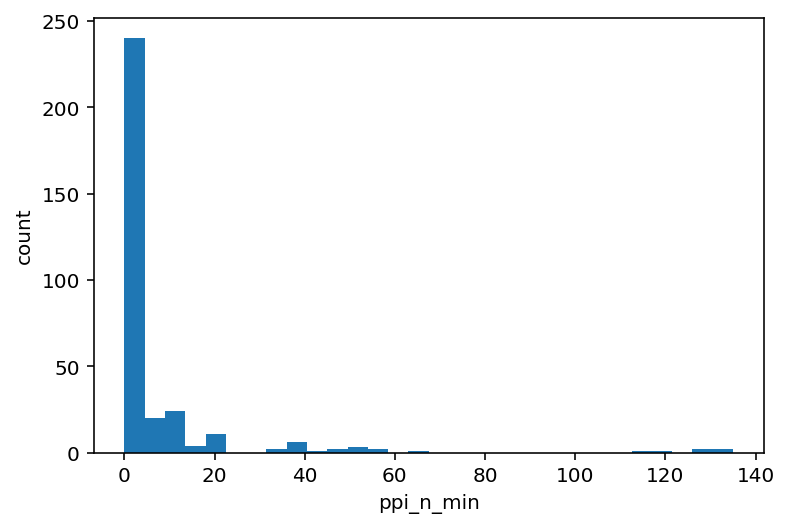

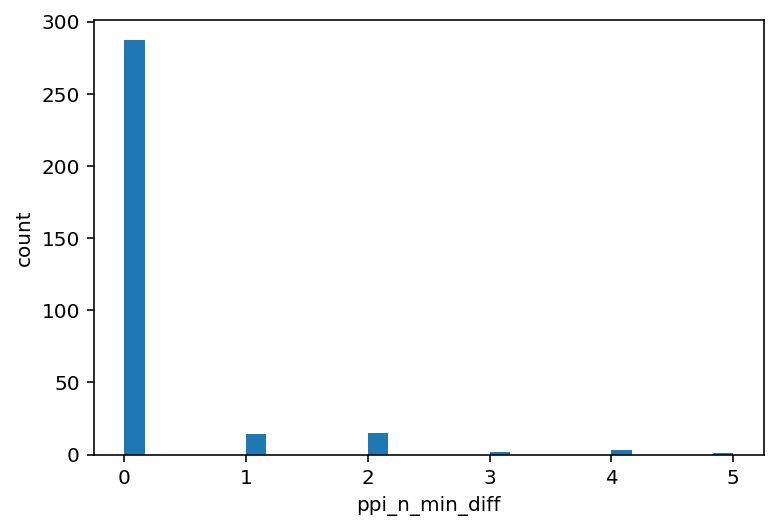

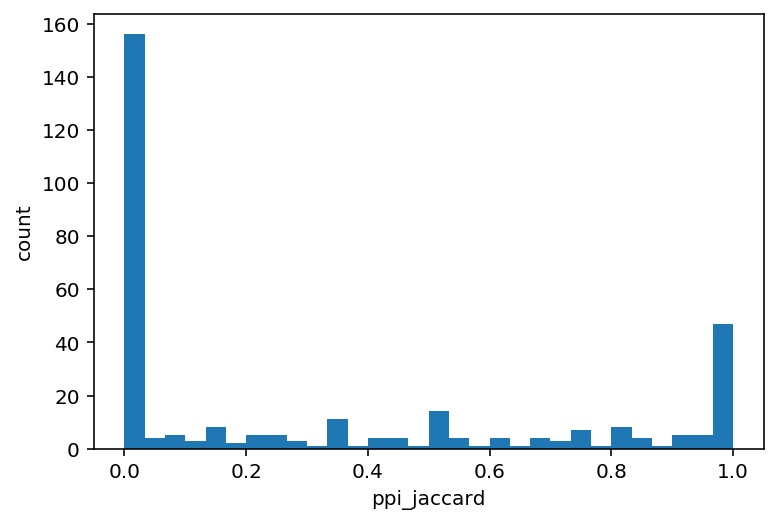

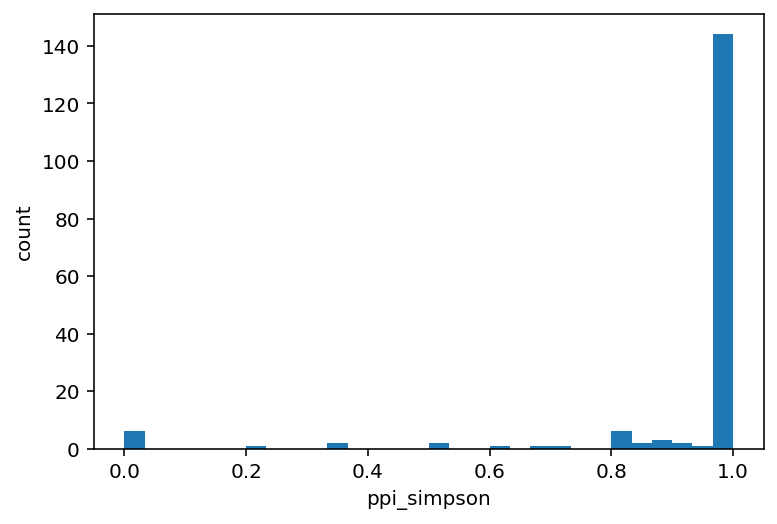

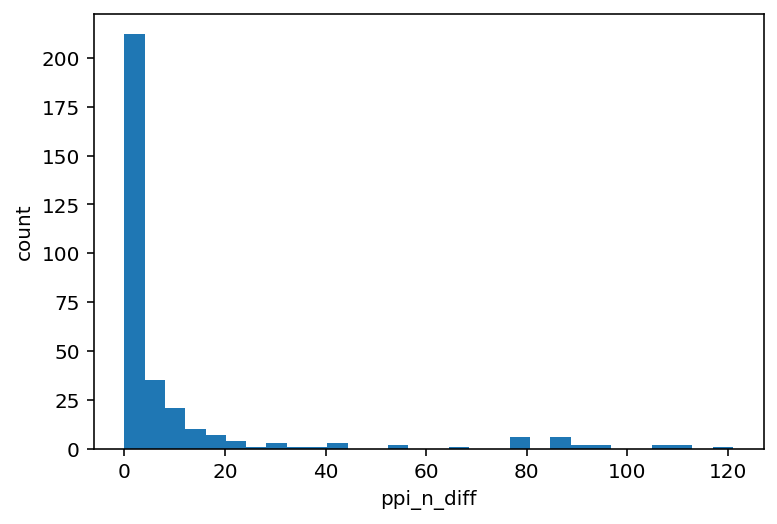

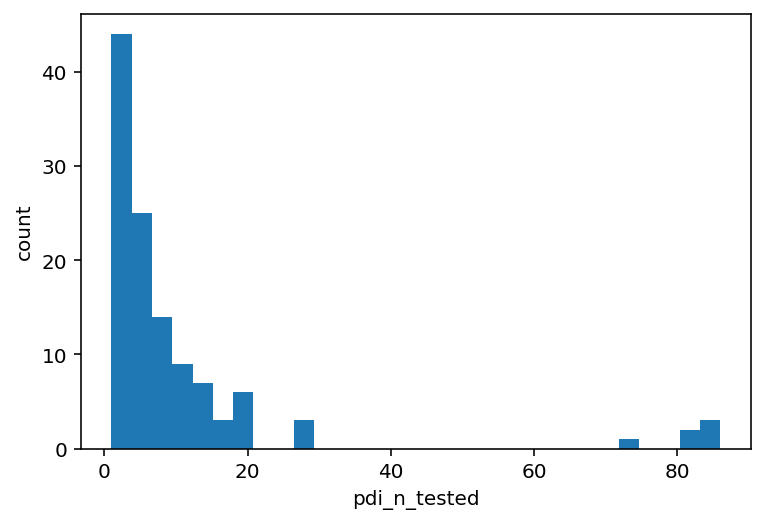

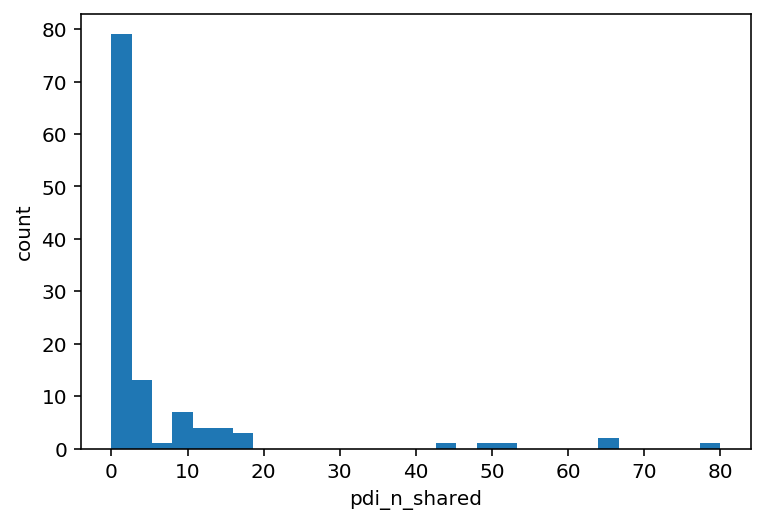

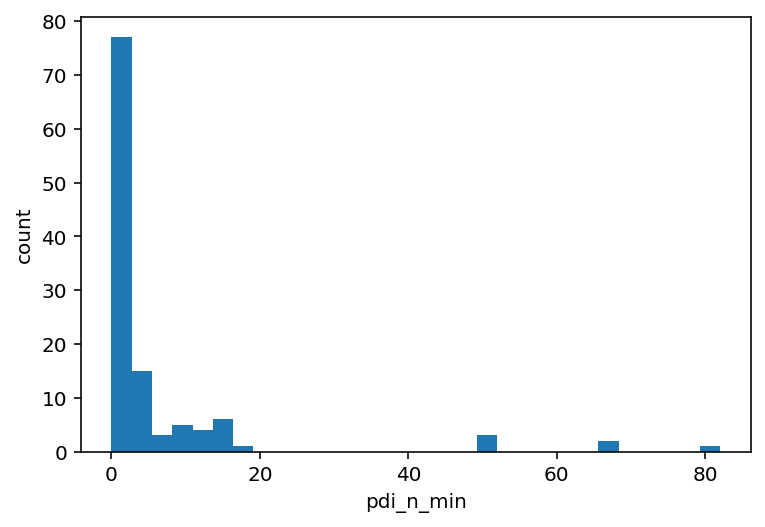

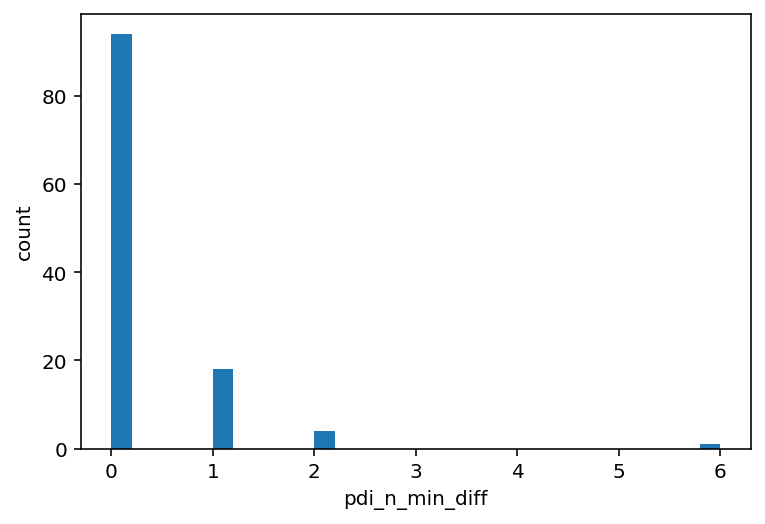

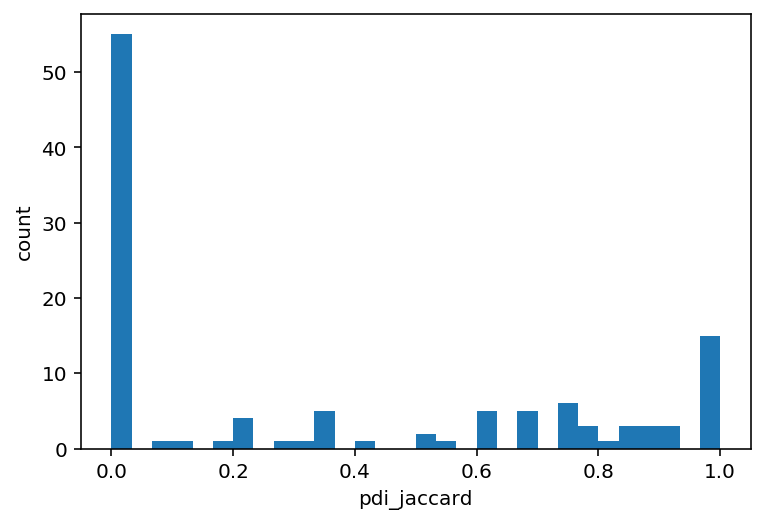

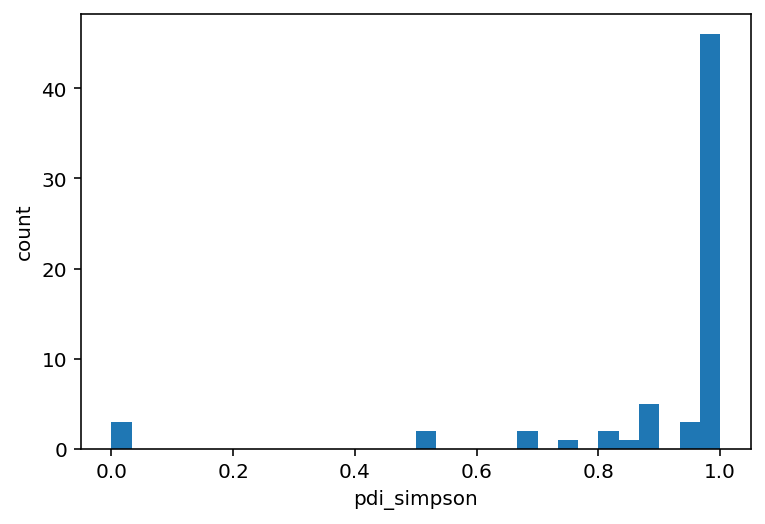

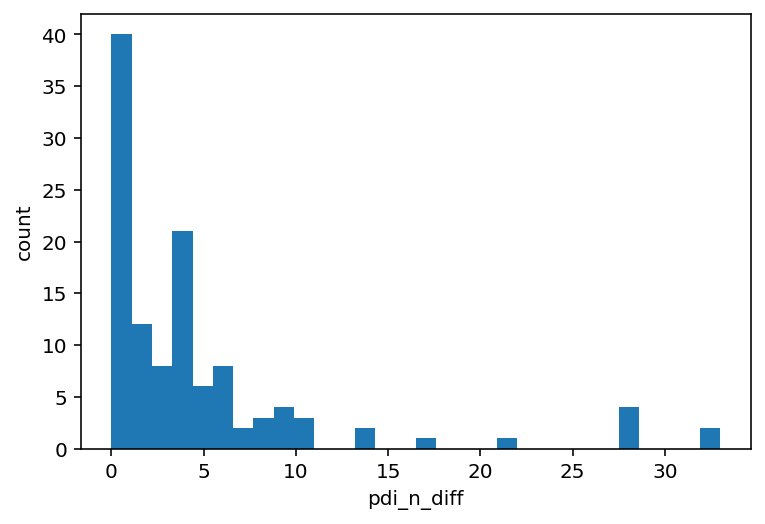

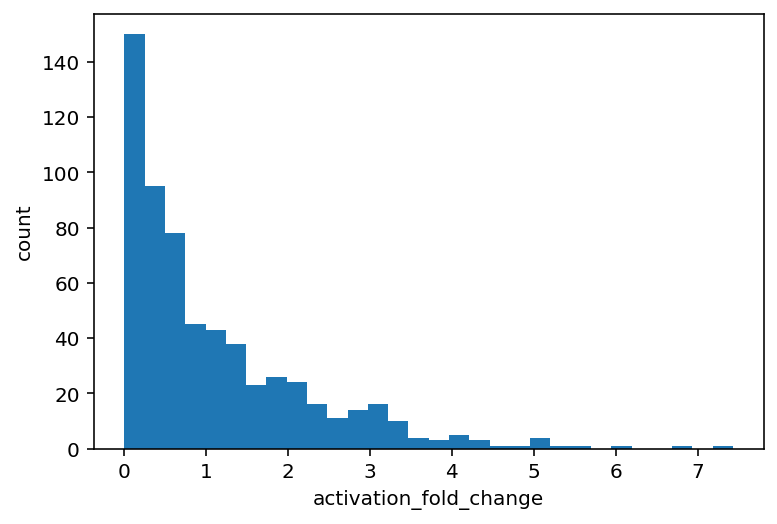

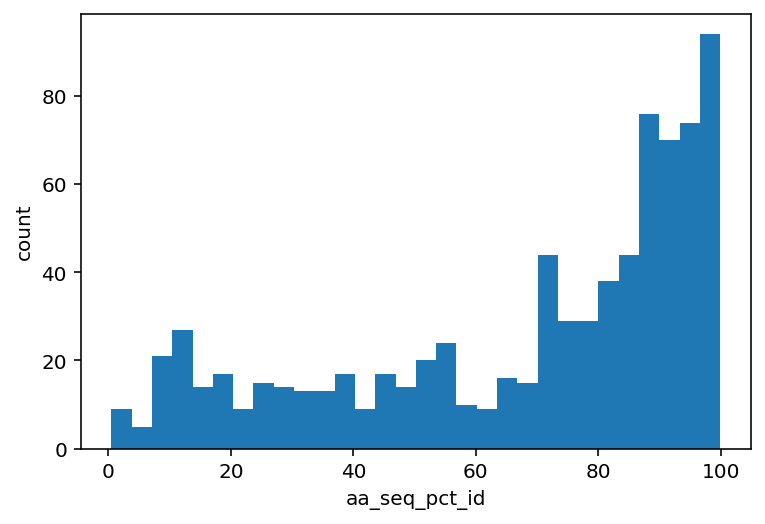

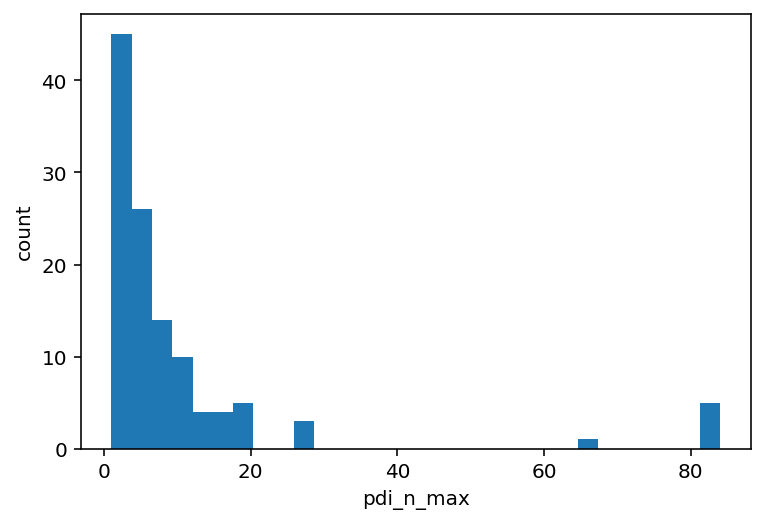

In [10]:
for col in iso_pairs.columns[4:]:
    plt.hist(iso_pairs[col], bins=30)
    plt.xlabel(col)
    plt.ylabel('count')
    plt.show()

In [11]:
iso_pairs.head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,...,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id,pdi_n_max
0,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,AEBP2|2/3|05F03_AEBP2|3/3|05E07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535619,82.0,NaN
1,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,ARNT2|1/6|08C12_ARNT2|2/6|09E01,13.0,7.0,8.0,1.0,0.538462,0.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.094800,93.0,NaN
2,ARNT2,ARNT2|1/6|08C12,ARNT2|3/6|10D11,ARNT2|1/6|08C12_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.7,NaN
3,ARNT2,ARNT2|2/6|09E01,ARNT2|3/6|10D11,ARNT2|2/6|09E01_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.1,NaN
4,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,ARNTL|1/2|08H08_ARNTL|2/2|08E08,2.0,0.0,0.0,0.0,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.3,NaN


### Explore PDI/PPI profile differences and sequence similarity

Look into:
- PPI and PDI Jaccard distribution
  - Faceted by degree
- PPI versus PDI Jaccard/Simpson
  - Faceted by number of interactors
- PPI/PDI Jaccard versus sequence similarity

TODO
- Compare randomly selected isoforms from different genes (from paralog data)

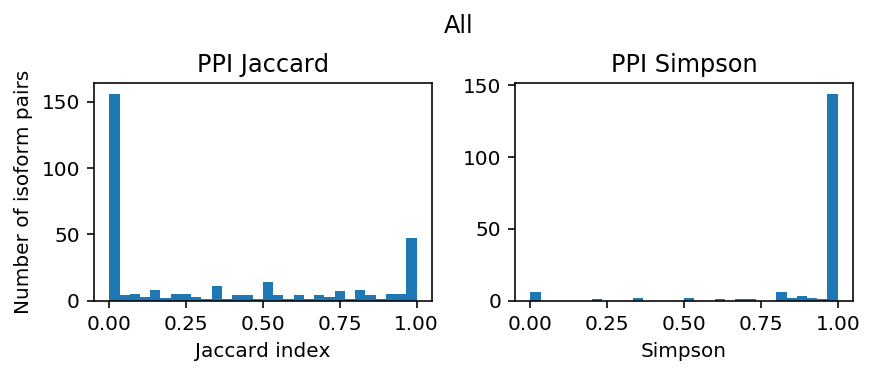

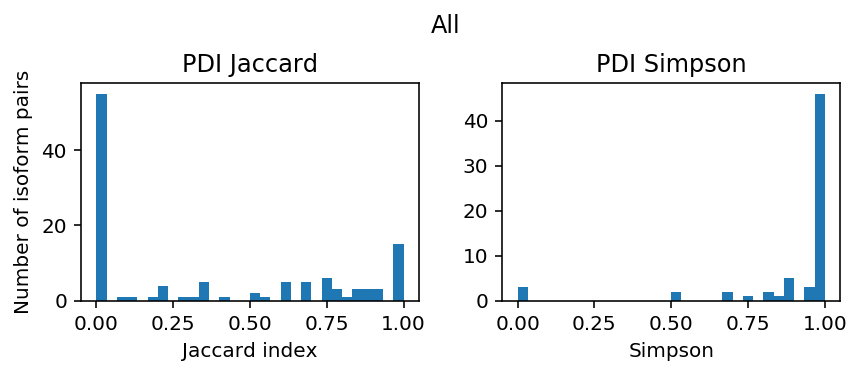

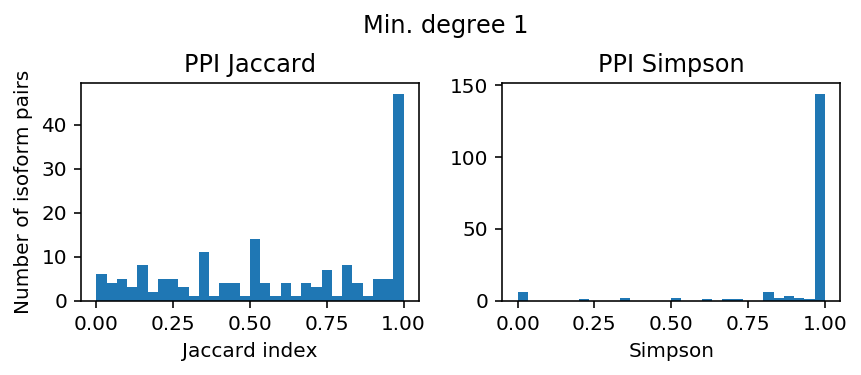

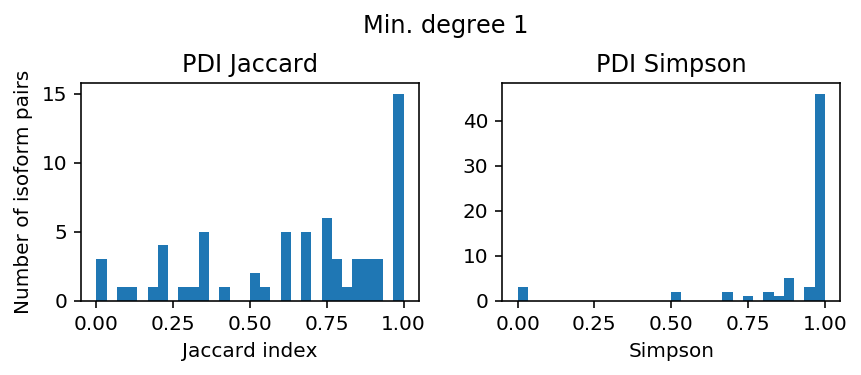

In [12]:
#  Jaccard/Simpson for PPI/PDI, histograms
def make_jaccard_simpson_hist(int_type, iso_pairs=iso_pairs, main_title='', nb=30):
    # int_type - ppi or pdi
    # nb - number of bins
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2.5))
    fig.suptitle(main_title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.87]) # adjust to allow for subtitle

    ax1.hist(iso_pairs[int_type + '_jaccard'], bins=nb)
    ax1.set_title(int_type.upper() + ' Jaccard')
    ax1.set_xlabel('Jaccard index')
    ax1.set_ylabel('Number of isoform pairs')
    
    ax2.hist(iso_pairs[int_type + '_simpson'], bins=nb)
    ax2.set_title(int_type.upper() + ' Simpson')
    ax2.set_xlabel('Simpson')
    
make_jaccard_simpson_hist('ppi', iso_pairs, 'All')
make_jaccard_simpson_hist('pdi', iso_pairs, 'All')
make_jaccard_simpson_hist('ppi', iso_pairs.loc[iso_pairs['ppi_n_min']>=1, :], main_title='Min. degree 1')
make_jaccard_simpson_hist('pdi', iso_pairs.loc[iso_pairs['pdi_n_min']>=1, :], main_title='Min. degree 1')


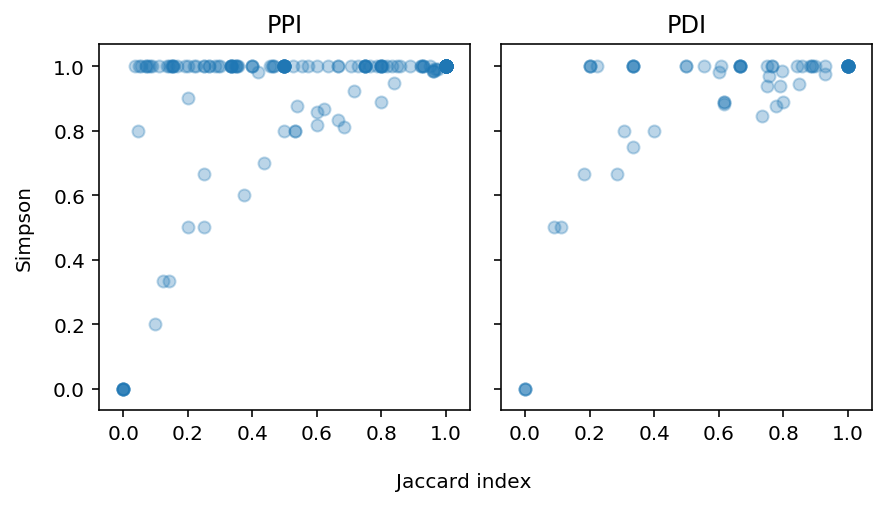

In [13]:
# Jaccard vs Simpson for PPI and PDI
def make_jaccard_simpson_plot(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

    alpha=0.3
    ax1.scatter(df.ppi_jaccard, df.ppi_simpson, alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_aspect('equal')
    ax2.scatter(df.pdi_jaccard, df.pdi_simpson, alpha=alpha)
    ax2.set_title('PDI')
    ax2.set_aspect('equal')

    fig.tight_layout()
    fig.text(0.5, 0.05, 'Jaccard index', ha='center')
    fig.text(-0.02, 0.5, 'Simpson', va='center', rotation='vertical')

make_jaccard_simpson_plot(iso_pairs) # only plotted for cases  with 1+ interactions for both iso. of a pair

SpearmanrResult(correlation=nan, pvalue=nan)

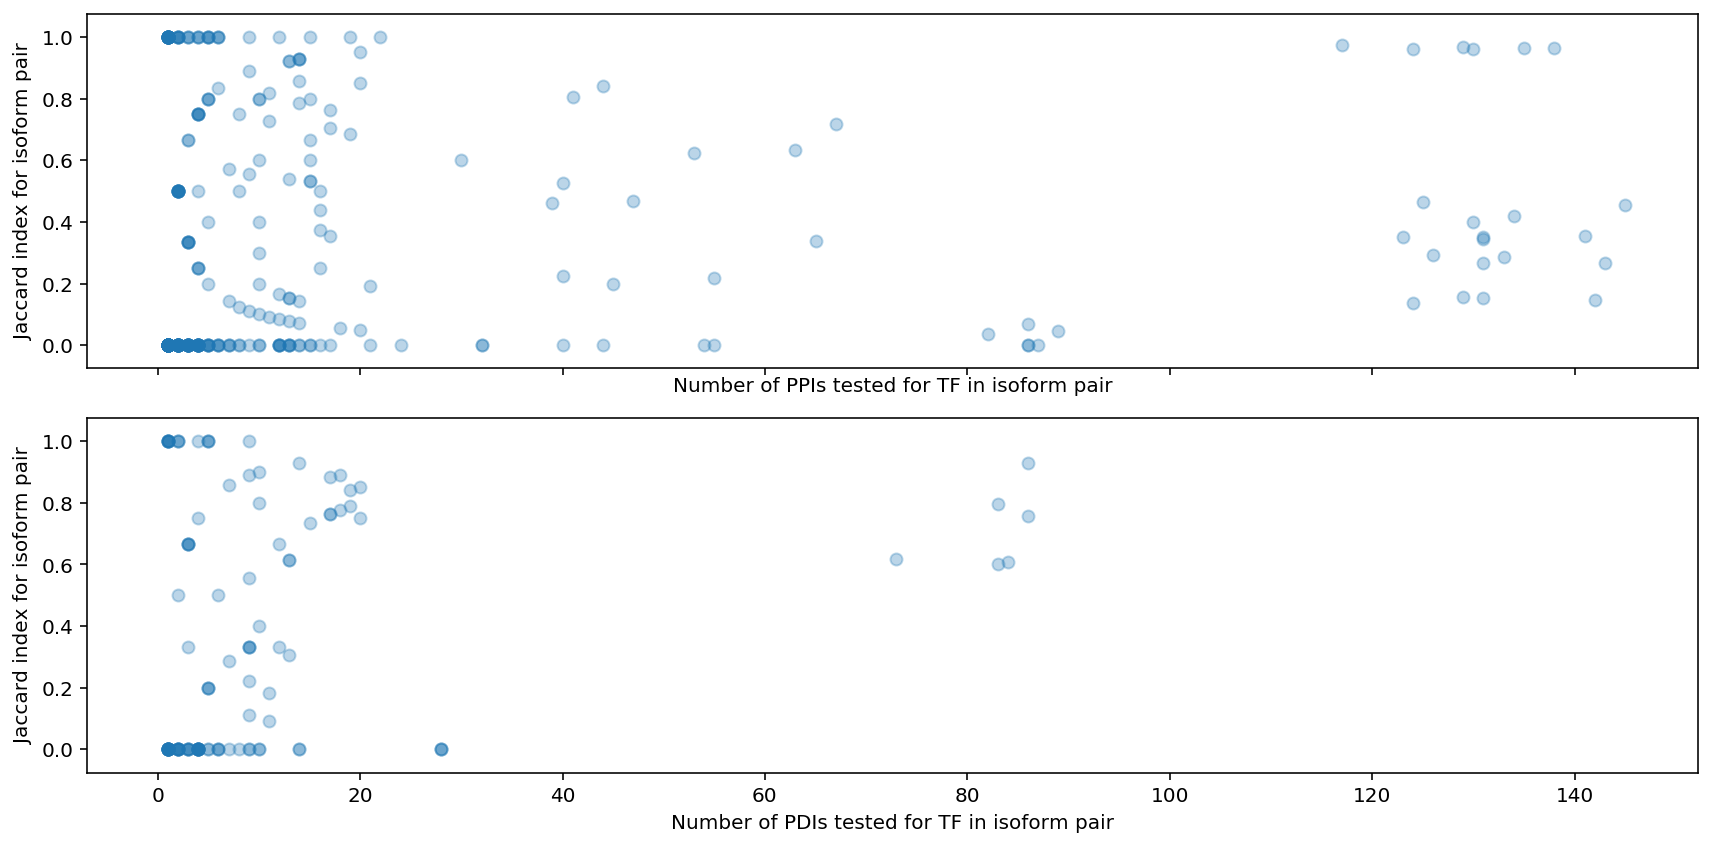

In [14]:
# Is there a relationship between degree and interaction profile similarity?
# For now use number of pdi/ppi tested as estimate of degree.
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(12,6))
alpha=0.3

ax1.scatter(iso_pairs.ppi_n_tested, iso_pairs.ppi_jaccard, alpha=alpha)
ax1.set_xlabel('Number of PPIs tested for TF in isoform pair')
ax1.set_ylabel('Jaccard index for isoform pair')

ax2.scatter(iso_pairs.pdi_n_tested, iso_pairs.pdi_jaccard, alpha=alpha)
ax2.set_xlabel('Number of PDIs tested for TF in isoform pair')
ax2.set_ylabel('Jaccard index for isoform pair')

fig.tight_layout()

# Luke question - how to determine if there is no bias between degree and Jaccard?
stats.spearmanr(iso_pairs.ppi_n_tested, iso_pairs.ppi_jaccard)
stats.spearmanr(iso_pairs.pdi_n_tested, iso_pairs.pdi_jaccard)

In [15]:
iso_pairs.sort_values(['ppi_jaccard', 'aa_seq_pct_id'], ascending=[True, False])

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,...,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id,pdi_n_max
531,TFEC,TFEC|5/6|04A01,TFEC|6/6|03E11,TFEC|5/6|04A01_TFEC|6/6|03E11,3.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.5,NaN
374,RBPJ,RBPJ|2/4|07B11,RBPJ|3/4|07D11,RBPJ|2/4|07B11_RBPJ|3/4|07D11,1.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.707642,99.0,NaN
136,GRHL3,GRHL3|2/7|08A10,GRHL3|3/7|08G09,GRHL3|2/7|08A10_GRHL3|3/7|08G09,2.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.187733,98.4,NaN
282,NFIA,NFIA|2/5|02G09,NFIA|3/5|02E09,NFIA|2/5|02G09_NFIA|3/5|02E09,1.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.845586,98.2,NaN
373,RBPJ,RBPJ|1/4|01F06,RBPJ|3/4|07D11,RBPJ|1/4|01F06_RBPJ|3/4|07D11,1.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250248,98.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,ZFP1,ZFP1|2/4|04D02,ZFP1|4/4|04C01,ZFP1|2/4|04D02_ZFP1|4/4|04C01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.957208,2.1,NaN
584,ZFP1,ZFP1|1/4|04C02,ZFP1|4/4|04C01,ZFP1|1/4|04C02_ZFP1|4/4|04C01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.345009,2.0,NaN
626,ZNF180,ZNF180|1/4|10E12,ZNF180|4/4|02C10,ZNF180|1/4|10E12_ZNF180|4/4|02C10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.916642,1.6,NaN
206,KLF7,KLF7|7/8|10H08,KLF7|8/8|10D09,KLF7|7/8|10H08_KLF7|8/8|10D09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN


SpearmanrResult(correlation=0.5250707342664515, pvalue=3.2535746098522558e-24)


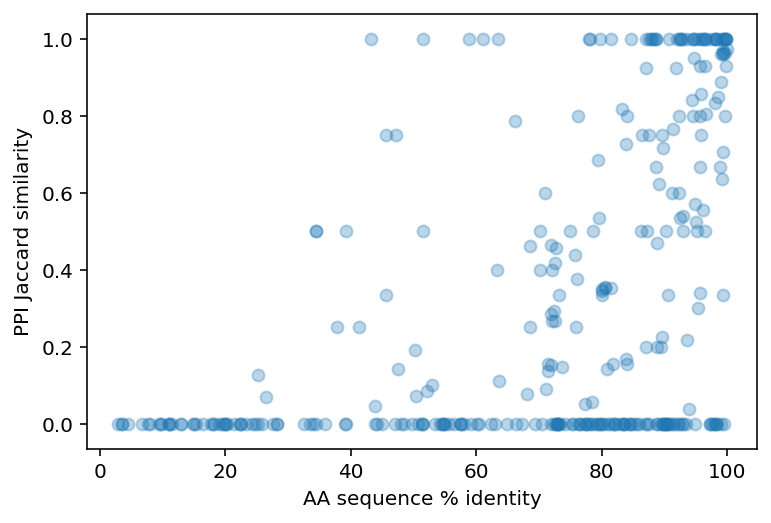

In [16]:
x = iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull(), 'ppi_jaccard'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('PPI Jaccard similarity')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../../figures/ppi_jaccard_vs_aa_id.pdf',
            bbox_inches='tight')

SpearmanrResult(correlation=0.42001130703951567, pvalue=2.426029295305715e-06)


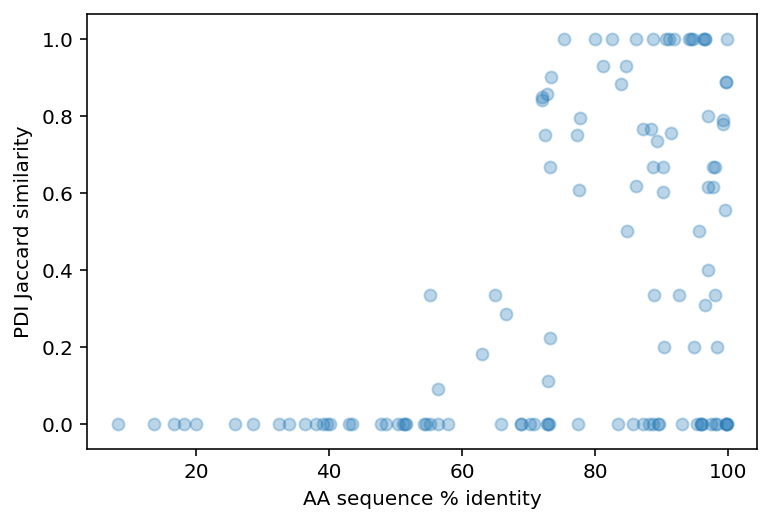

In [17]:
x = iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(), 'pdi_jaccard'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('PDI Jaccard similarity')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../../figures/pdi_jaccard_vs_aa_id.pdf',
            bbox_inches='tight')

SpearmanrResult(correlation=-0.34780169867529054, pvalue=6.301558418393862e-19)


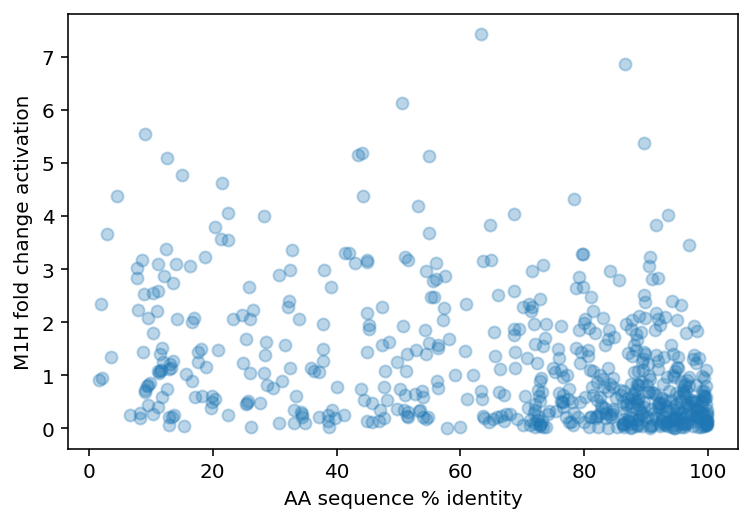

In [18]:
x = iso_pairs.loc[iso_pairs['activation_fold_change'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['activation_fold_change'].notnull(), 'activation_fold_change'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('M1H fold change activation')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../../figures/m1h_fold_change_vs_aa_id.pdf',
            bbox_inches='tight')

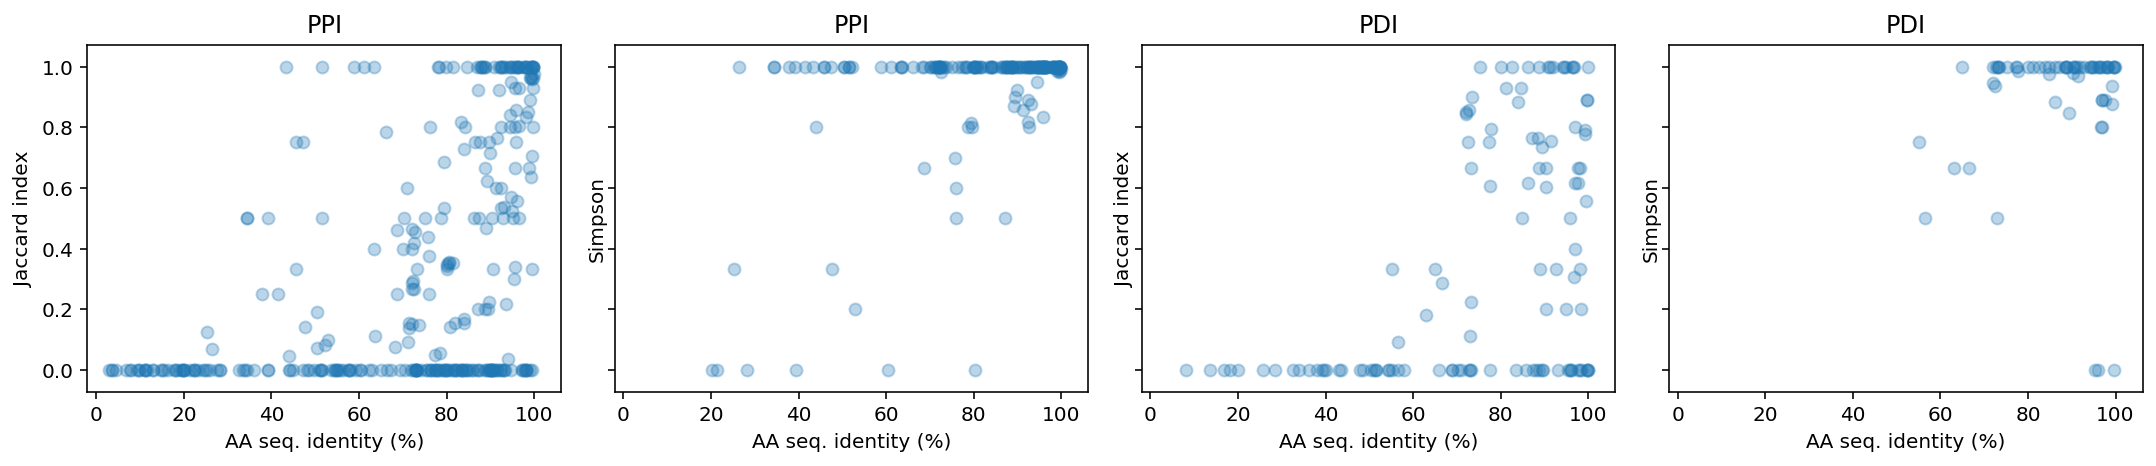

In [19]:
# Jaccard/Simpson versus similarity for PPI and PDI
def make_profile_diff_vs_seq_plot(df):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15,3))
    fig.tight_layout()
    (ax1, ax2, ax3, ax4) = axs
    
    for ax in axs: ax.set_xlabel('AA seq. identity (%)')
        
    alpha=0.3
    
    ax1.scatter(df.aa_seq_pct_id, df.ppi_jaccard, alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_ylabel('Jaccard index')
    ax2.scatter(df.aa_seq_pct_id, df.ppi_simpson, alpha=alpha)
    ax2.set_title('PPI')
    ax2.set_ylabel('Simpson')
    ax3.scatter(df.aa_seq_pct_id, df.pdi_jaccard, alpha=alpha)
    ax3.set_title('PDI')
    ax3.set_ylabel('Jaccard index')
    ax4.scatter(df.aa_seq_pct_id, df.pdi_simpson, alpha=alpha)
    ax4.set_title('PDI')
    ax4.set_ylabel('Simpson')

make_profile_diff_vs_seq_plot(iso_pairs)

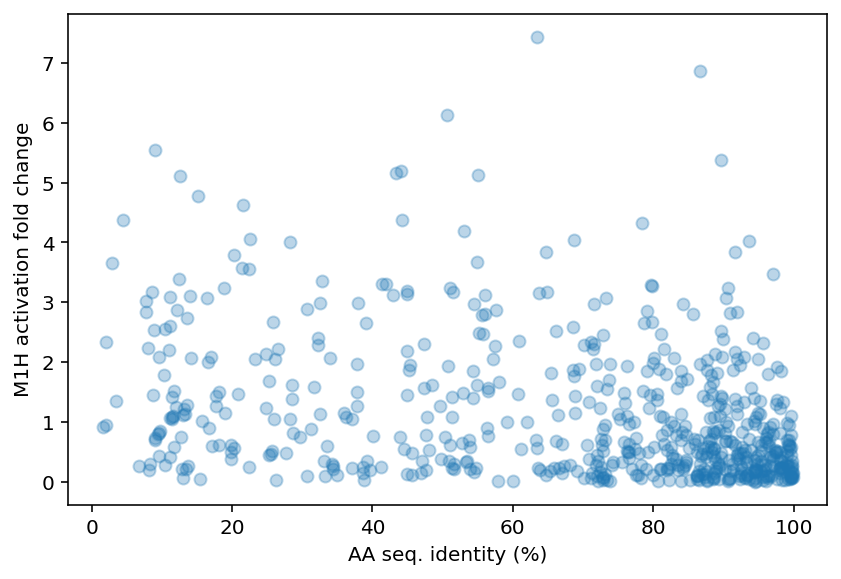

In [20]:
# Jaccard/Simpson versus similarity for M1H
fig, ax1 = plt.subplots(1, sharex=True, sharey=True)
fig.tight_layout()
alpha=0.3
ax1.scatter(iso_pairs.aa_seq_pct_id, iso_pairs.activation_fold_change, alpha=alpha)
ax1.set_xlabel('AA seq. identity (%)')
ax1.set_ylabel('M1H activation fold change')
plt.savefig('../../figures/M1H_fold_change_vs_aa_id.pdf',
            bbox_inches='tight')

In [21]:
# get isoform-specific y1h and y2h degree
deg = y1h.loc[:, y1h.columns[2:]].sum(axis=1).rename('y1h_degree')
y1h_nd = y1h[['tf', 'unique_acc']].join(deg, how='left')
y2h_nd = y2h.loc[y2h.category=='tf_isoform_ppis', :].groupby('ad_clone_acc')['ad_clone_acc'].count().rename('y2h_degree')
int_nd = y1h_nd.join(y2h_nd, how='outer', on='unique_acc')
int_nd.head()

,tf,unique_acc,y1h_degree,y2h_degree
162.0,CREB1,CREB1|1/2|02E01,0.0,1.0
0.0,CREB1,CREB1|2/2|01F12,3.0,1.0
1.0,DLX1,DLX1|1/2|07A12,9.0,NaN
174.0,DLX1,DLX1|2/2|07E09,0.0,NaN
2.0,DLX4,DLX4|1/3|11A04,3.0,1.0


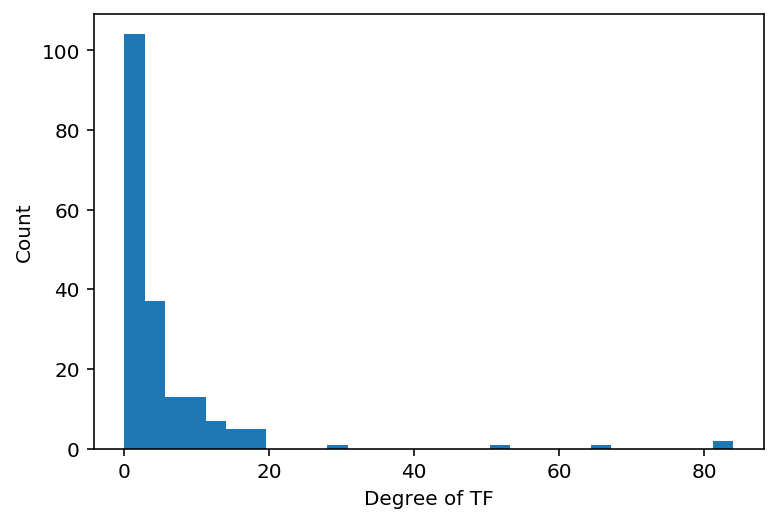

Text(0, 0.5, 'Count')

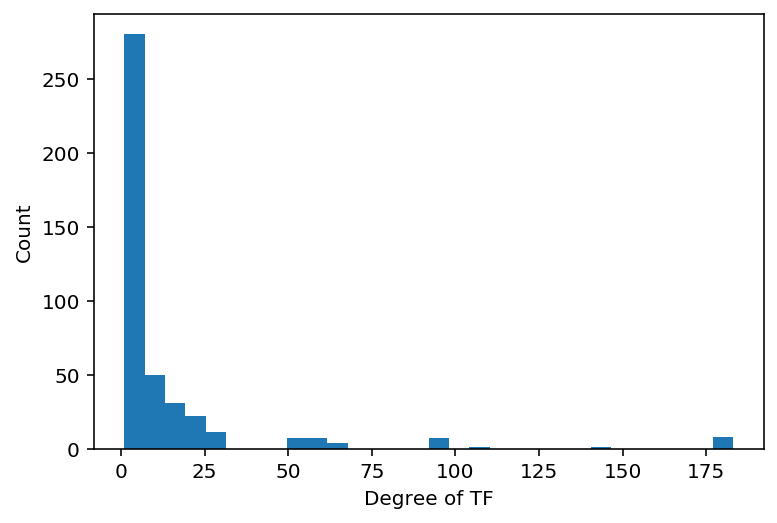

In [22]:
# plot the degree distributions
# degere of y1h
plt.hist(int_nd.y1h_degree.dropna(), bins=30) 
plt.xlabel('Degree of TF')
plt.ylabel('Count')
plt.show()
plt.hist(int_nd.y2h_degree.dropna(), bins=30) 
plt.xlabel('Degree of TF')
plt.ylabel('Count')

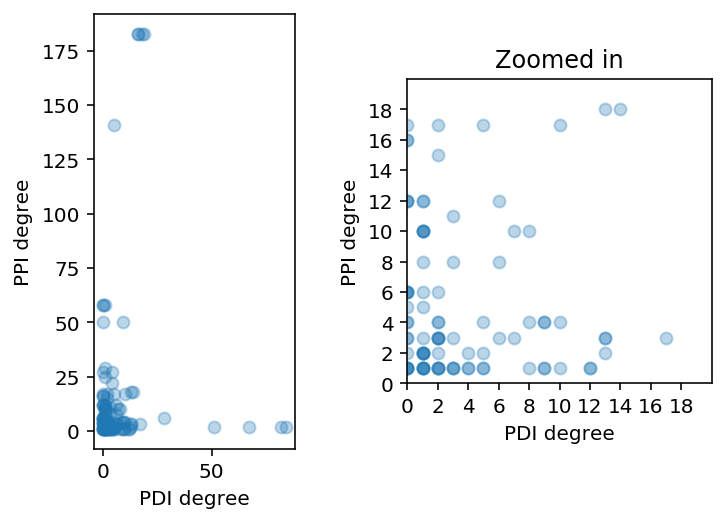

In [23]:
# compare pdi versus ppi degree
fig, (ax1, ax2) = plt.subplots(1,2)
alpha = 0.3

ax1.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax1.set_aspect('equal')
ax1.set_xlabel('PDI degree')
ax1.set_ylabel('PPI degree')

ax2.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax2.set_aspect('equal')
ax2.set_xlabel('PDI degree')
ax2.set_ylabel('PPI degree')
ax2.set_title('Zoomed in')
ax2.set_xlim(0,20)
ax2.set_xticks(range(0,20,2))
ax2.set_ylim(0,20)
ax2.set_yticks(range(0,20,2));
# ax2.set_yscale('log')
# ax2.set_xscale('log')


SpearmanrResult(correlation=-0.25895120937514443, pvalue=2.0407302268824557e-05)


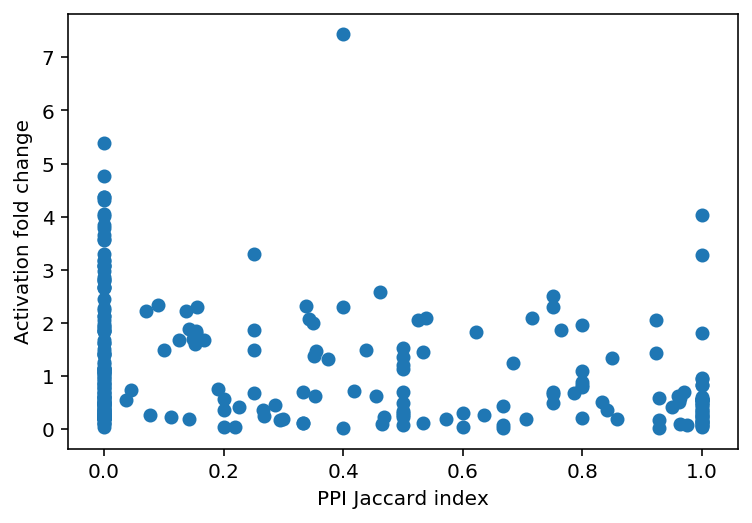

In [24]:
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
plt.scatter(xy[x], xy[y])
plt.xlabel('PPI Jaccard index')
plt.ylabel('Activation fold change')
print(stats.spearmanr(xy[x], xy[y]))
plt.savefig('../../figures/ppi_vs_activation.pdf',
            bbox_inches='tight')

(104, 21)
SpearmanrResult(correlation=-0.2500113196982098, pvalue=0.010479425843809722)


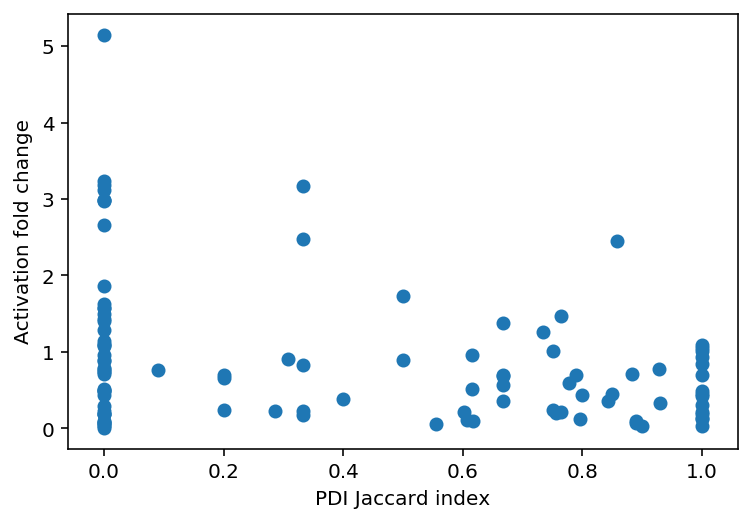

In [25]:
x = 'pdi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y])
plt.xlabel('PDI Jaccard index')
plt.ylabel('Activation fold change')
print(stats.spearmanr(xy[x], xy[y]))
plt.savefig('../../figures/pdi_vs_activation.pdf',
            bbox_inches='tight')

(58, 21)


SpearmanrResult(correlation=0.23682441769768278, pvalue=0.07347055427844947)

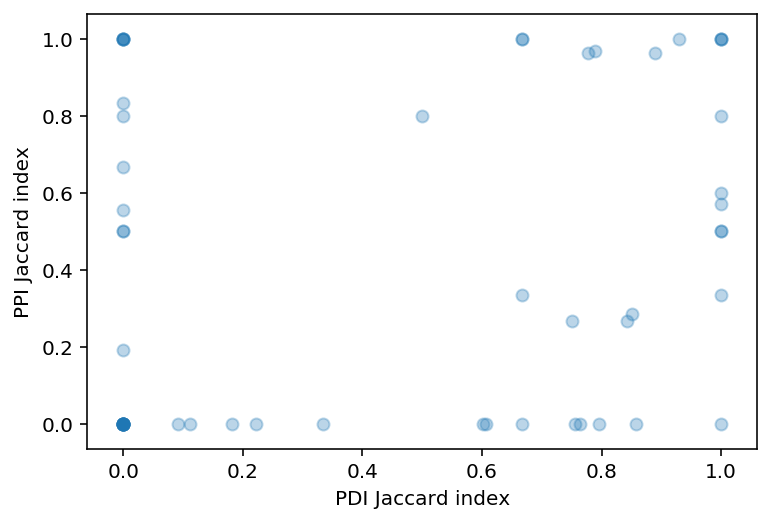

In [26]:
x = 'pdi_jaccard'
y = 'ppi_jaccard'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
plt.xlabel('PDI Jaccard index')
plt.ylabel('PPI Jaccard index')
stats.spearmanr(xy[x], xy[y])

In [27]:
x = 'pdi_jaccard'
y = 'ppi_jaccard'
print(iso_pairs['ppi_n_min']>=1)
print(iso_pairs[x].notnull())

0      False
1       True
2      False
3      False
4      False
       ...  
801    False
802    False
803    False
804    False
805     True
Name: ppi_n_min, Length: 806, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
801    False
802    False
803    False
804    False
805    False
Name: pdi_jaccard, Length: 806, dtype: bool


(23, 21)


SpearmanrResult(correlation=-0.15248792336100572, pvalue=0.4873041214237478)

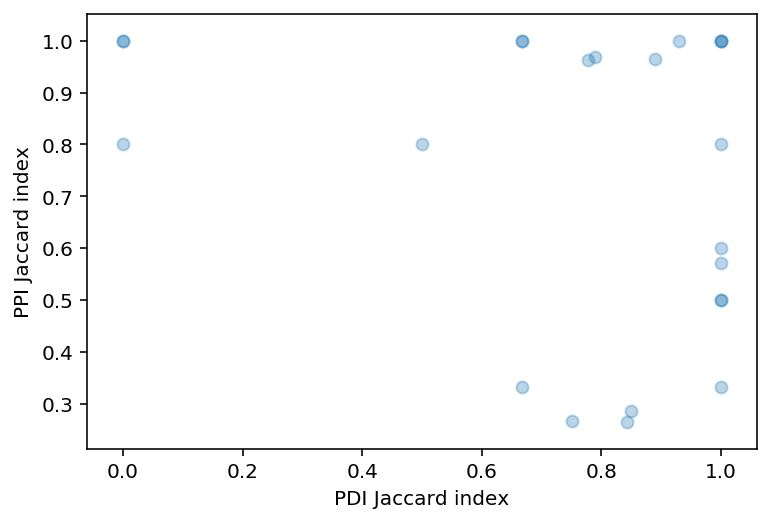

In [28]:
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull() & (iso_pairs['ppi_n_min']>=1) & (iso_pairs['pdi_n_min']>=1), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
plt.xlabel('PDI Jaccard index')
plt.ylabel('PPI Jaccard index')
stats.spearmanr(xy[x], xy[y])

In [29]:
# Look at direction of activation change? I.e. is the isoform with less binding partners
# the one with activation closer to 0?

In [30]:
iso_pairs.sort_values('ppi_n_min_diff',
                      ascending=False).head(20)

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,...,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id,pdi_n_max
468,TCF4,TCF4|5/9|07C02,TCF4|8/9|07A05,TCF4|5/9|07C02_TCF4|8/9|07A05,53.0,33.0,38.0,5.0,0.622642,0.868421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.825006,89.1,NaN
568,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|4/9|10H06,ZBTB44|1/9|12B06_ZBTB44|4/9|10H06,16.0,6.0,10.0,4.0,0.375000,0.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.324958,76.0,NaN
467,TCF4,TCF4|5/9|07C02,TCF4|7/9|07G03,TCF4|5/9|07C02_TCF4|7/9|07G03,67.0,48.0,52.0,4.0,0.716418,0.923077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.090708,89.8,NaN
726,ZNF451,ZNF451|6/8|05H11,ZNF451|7/8|06D01,ZNF451|6/8|05H11_ZNF451|7/8|06D01,10.0,1.0,5.0,4.0,0.100000,0.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.485041,52.9,NaN
324,PATZ1,PATZ1|1/4|02C02,PATZ1|3/4|02A04,PATZ1|1/4|02C02_PATZ1|3/4|02A04,19.0,13.0,16.0,3.0,0.684211,0.812500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.239169,79.4,NaN
569,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|5/9|10H05,ZBTB44|1/9|12B06_ZBTB44|5/9|10H05,16.0,7.0,10.0,3.0,0.437500,0.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.493713,75.8,NaN
445,TCF4,TCF4|1/9|07E01,TCF4|3/9|07C04,TCF4|1/9|07E01_TCF4|3/9|07C04,124.0,119.0,121.0,2.0,0.959677,0.983471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.621134,99.4,NaN
570,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|6/9|12H02,ZBTB44|1/9|12B06_ZBTB44|6/9|12H02,15.0,8.0,10.0,2.0,0.533333,0.800000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.445209,79.5,NaN
716,ZNF451,ZNF451|3/8|06A03,ZNF451|6/8|05H11,ZNF451|3/8|06A03_ZNF451|6/8|05H11,7.0,1.0,3.0,2.0,0.142857,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.201770,47.6,NaN
717,ZNF451,ZNF451|3/8|06A03,ZNF451|7/8|06D01,ZNF451|3/8|06A03_ZNF451|7/8|06D01,8.0,1.0,3.0,2.0,0.125000,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.686811,25.3,NaN


In [31]:
# Check if this result is robust against requiring at least
# one interaction partner for both genes.
# To see if the effect is driven by non-functional isoforms.
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() &
                   iso_pairs[y].notnull() &
                   (iso_pairs['ppi_n_min'] >= 1), :]
print(xy.shape)
stats.spearmanr(xy[x], xy[y])

(144, 21)


SpearmanrResult(correlation=-0.29577710890989056, pvalue=0.00031911555912838153)

In [32]:
xy.sort_values('activation_fold_change', ascending=False).head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,...,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id,pdi_n_max
47,E2F3,E2F3|2/4|10A08,E2F3|3/4|10B08,E2F3|2/4|10A08_E2F3|3/4|10B08,5.0,2.0,2.0,0.0,0.4,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.433645,63.4,NaN
301,NR4A1,NR4A1|1/5|03A04,NR4A1|2/5|03G05,NR4A1|1/5|03A04_NR4A1|2/5|03G05,1.0,1.0,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.029137,93.6,NaN
21,ATF2,ATF2|3/6|09C05,ATF2|5/6|09A05,ATF2|3/6|09C05_ATF2|5/6|09A05,4.0,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.012971,28.3,NaN
23,ATF2,ATF2|4/6|09B05,ATF2|5/6|09A05,ATF2|4/6|09B05_ATF2|5/6|09A05,4.0,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.793690,20.3,NaN
796,ZSCAN18,ZSCAN18|1/7|09F02,ZSCAN18|2/7|09A01,ZSCAN18|1/7|09F02_ZSCAN18|2/7|09A01,17.0,0.0,2.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.572874,21.4,NaN


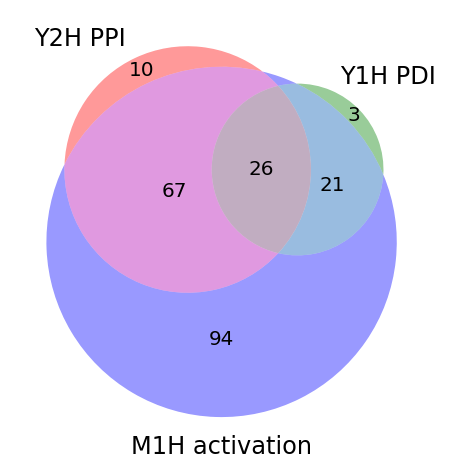

In [34]:
# overlaps

a = set(iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull(), 'tf_gene_symbol'].unique())
b = set(iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(), 'tf_gene_symbol'].unique())
c = set(iso_pairs.loc[iso_pairs['activation_fold_change'].notnull(), 'tf_gene_symbol'].unique())
from matplotlib_venn import venn3

venn3([a, b, c],
      set_labels=['Y2H PPI', 'Y1H PDI', 'M1H activation'])
plt.savefig('../../figures/tf_gene_data_integration_venn.pdf')

In [35]:
ppi.score.value_counts()

1     2175
0     1877
NS     109
AA      93
NC      93
NA      38
Name: score, dtype: int64

In [36]:
ppi.score.isin(['0', '1']).sum() / ppi.shape[0]

0.9240592930444698

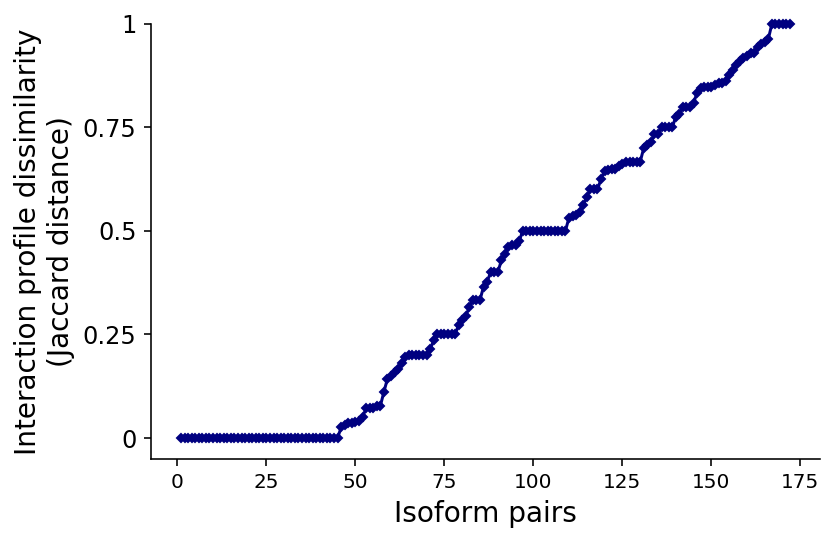

In [37]:
def remake_yang_et_al_fig_2b(values, color='navy'):
    ax.plot(range(1, values.shape[0] + 1),
            sorted(values),
            marker='D',
            markersize=3,
            color=color,
            clip_on=False)
    ax.set_xlabel('Isoform pairs', fontsize=14)
    ax.set_ylabel('Interaction profile dissimilarity\n(Jaccard distance)',
                  fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['{:g}'.format(t) for t in ax.get_yticks()],
                       fontsize=12)
    ax.set_ylim(ax.get_ylim()[0], 1)
    

fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull() &
                       (iso_pairs['ppi_n_min'] >= 1),
                       'ppi_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../../figures/remake_yang_et_al_fig4B.pdf',
            bbox_inches='tight')

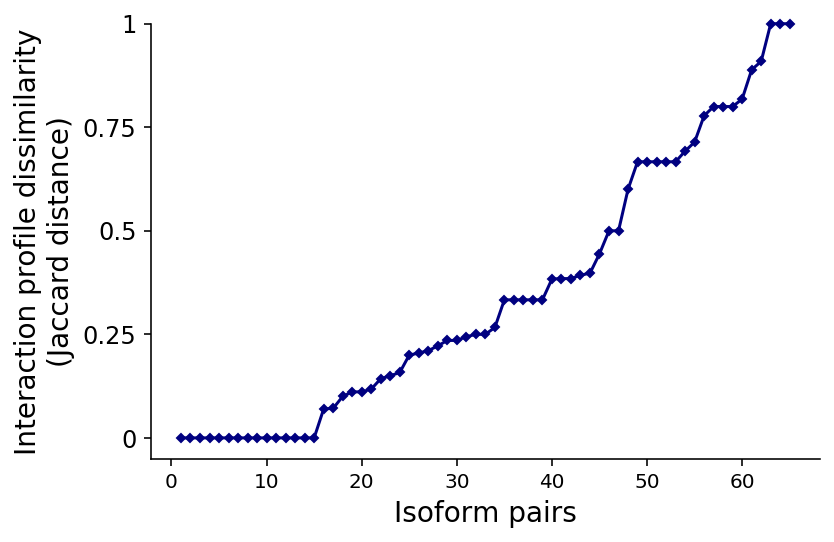

In [38]:
fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull() &
                       (iso_pairs['pdi_n_min'] >= 1),
                       'pdi_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../../figures/remake_yang_et_al_fig4B_PDI.pdf',
            bbox_inches='tight')

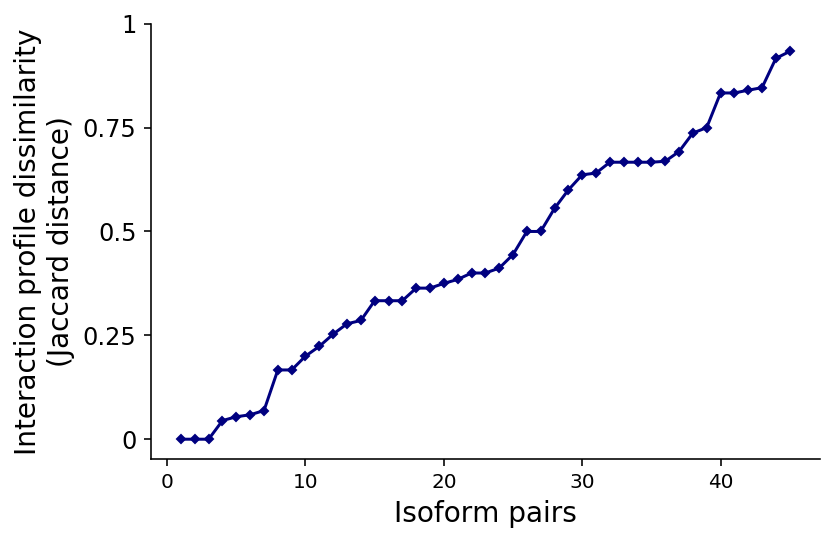

In [39]:
# combine PPI and PDI
iso_pairs['ppi_pdi_jaccard'] = ((iso_pairs['ppi_n_shared'] + iso_pairs['pdi_n_shared']) / 
                                (iso_pairs['ppi_n_tested'] + iso_pairs['pdi_n_tested']))
fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) | (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_pdi_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../../figures/remake_yang_et_al_fig4B_combine_PDI_PPI.pdf',
            bbox_inches='tight')

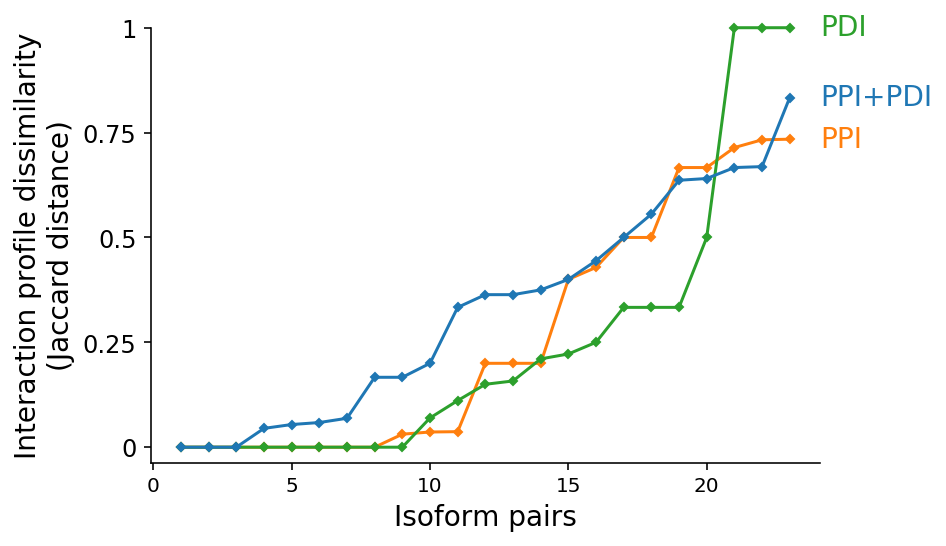

In [40]:
# all on one plot
fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'pdi_jaccard'].values
values_ppi_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_pdi_jaccard'].values
remake_yang_et_al_fig_2b(values_ppi, color='C1')
remake_yang_et_al_fig_2b(values_pdi, color='C2')
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        values_pdi.max(), 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max(), 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../../figures/remake_yang_et_al_fig4B_all_one_plot.pdf',
            bbox_inches='tight')

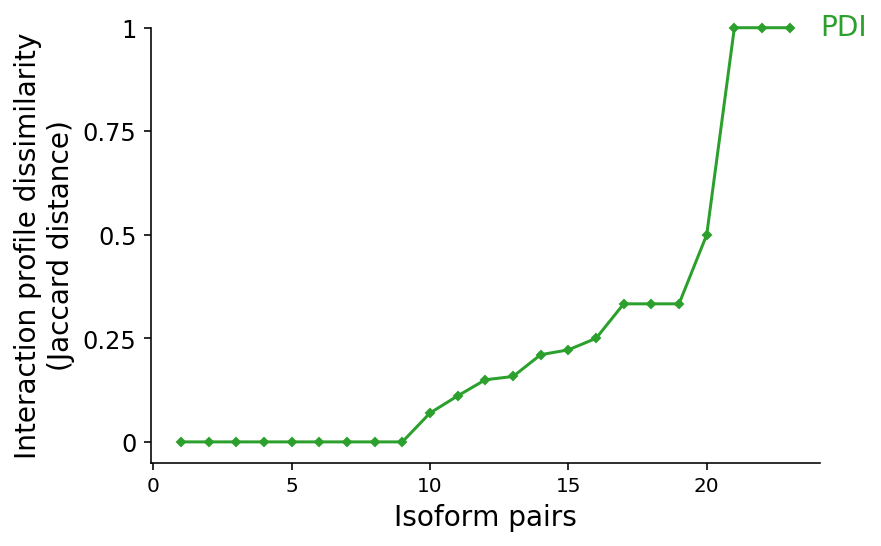

In [42]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_pdi, color='C2')
ax.text(ax.get_xlim()[1], 
        values_pdi.max(), 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
plt.savefig('../../figures/remake_yang_et_al_fig4B_PDI.pdf',
            bbox_inches='tight')

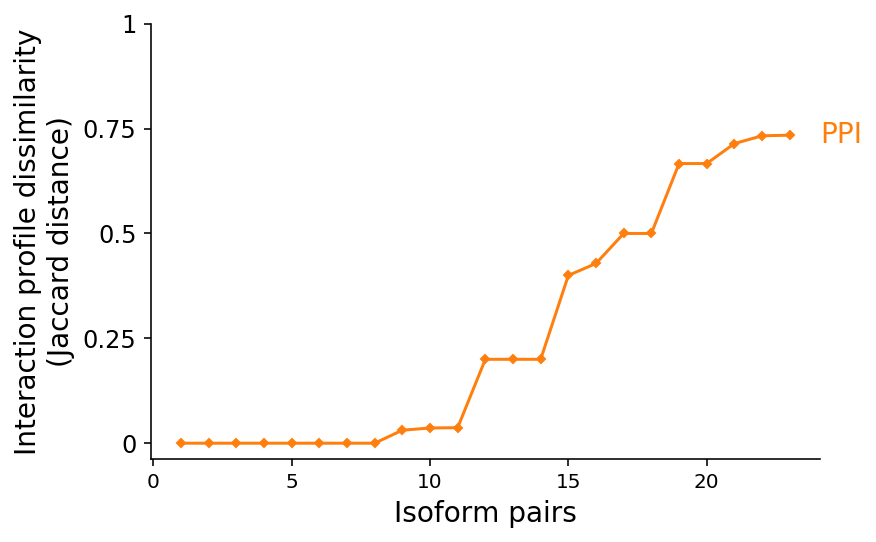

In [43]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_ppi, color='C1')
ax.text(ax.get_xlim()[1], 
        values_ppi.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
plt.savefig('../../figures/remake_yang_et_al_fig4B_PPI.pdf',
            bbox_inches='tight')

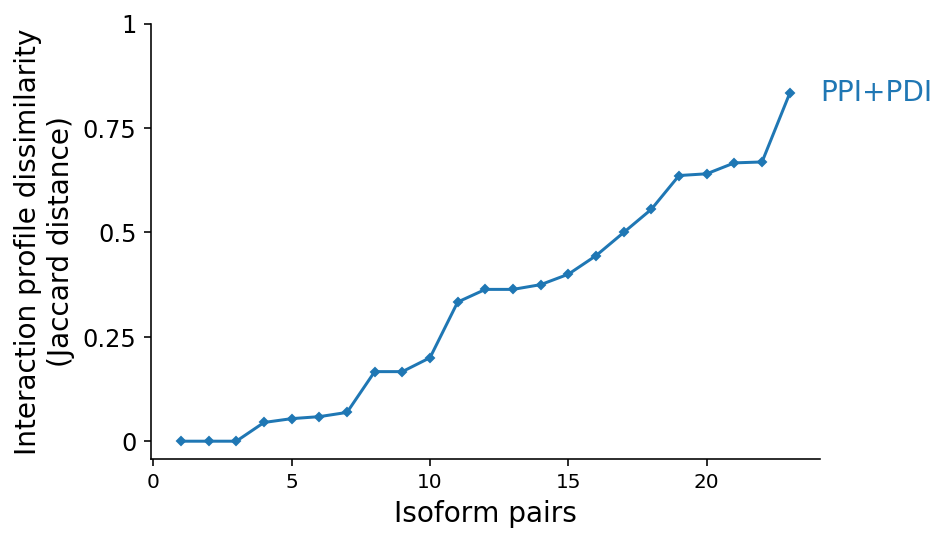

In [44]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max(), 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../../figures/remake_yang_et_al_fig4B_both.pdf',
            bbox_inches='tight')

In [ ]:
help(stats.wilcoxon)

In [ ]:
values_ppi

In [ ]:
values_ppi_pdi

In [ ]:
plt.hist(values_ppi_pdi - values_ppi)

In [ ]:
stats.ttest_rel(values_ppi, values_ppi_pdi)

In [ ]:
stats.wilcoxon(values_ppi, values_ppi_pdi)

In [ ]:
stats.ks_2samp(values_ppi, values_ppi_pdi)

In [ ]:
def remake_yang_et_al_fig_2b_pct_x(values, color='navy'):
    ax.plot(np.linspace(0, 100, values.shape[0] + 1)[1:],
            sorted(values),
            marker='D',
            markersize=3,
            color=color,
            clip_on=False)
    ax.set_xlabel('Percentage Isoform pairs', fontsize=14)
    ax.set_ylabel('Interaction profile dissimilarity\n(Jaccard distance)',
                  fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['{:g}'.format(t) for t in ax.get_yticks()],
                       fontsize=12)
    ax.set_ylim(ax.get_ylim()[0], 1)


fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1)),
                       'ppi_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull() &
                       ((iso_pairs['pdi_n_min'] >= 1)),
                       'pdi_jaccard'].values
values_ppi_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) | (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_pdi_jaccard'].values
remake_yang_et_al_fig_2b_pct_x(values_ppi, color='C1')
remake_yang_et_al_fig_2b_pct_x(values_pdi, color='C2')
remake_yang_et_al_fig_2b_pct_x(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        0.93, 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        0.86, 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        1, 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../../figures/remake_yang_et_al_fig4B_all_one_plot_pct_isoforms.pdf',
            bbox_inches='tight')

In [ ]:
stats.ks_2samp(values_ppi, values_ppi_pdi)

In [ ]:
stats.ks_2samp(values_pdi, values_ppi_pdi)

In [ ]:
iso_pairs.loc[(iso_pairs['pdi_jaccard'] == 0) &
              (iso_pairs['pdi_n_min'] >= 1), :]